1) Checking resources

In [1]:
!nvidia-smi

Mon Mar 28 11:58:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


2) Setting up colab

In [3]:
# Gloabal variables
data_path = "/content/gdrive/My Drive/ETH/MLH/Project1/data/"
model_path = "/content/gdrive/My Drive/ETH/MLH/Project1/model/"

random_seed = 50

In [4]:
# Mount Google Drive and set data paths.
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


3) Imports

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, optimizers, losses
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

4) Loading data

In [6]:
df_train = pd.read_csv(data_path + "input/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv(data_path + "input/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
Y = tf.keras.utils.to_categorical(Y)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
Y_test = tf.keras.utils.to_categorical(Y_test)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

print("X shape is {}".format(X.shape))
print("Y shape is {}".format(Y.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X shape is (87554, 187, 1)
Y shape is (87554, 5)
X_test shape is (21892, 187, 1)
Y_test shape is (21892, 5)


5) Visualizing data

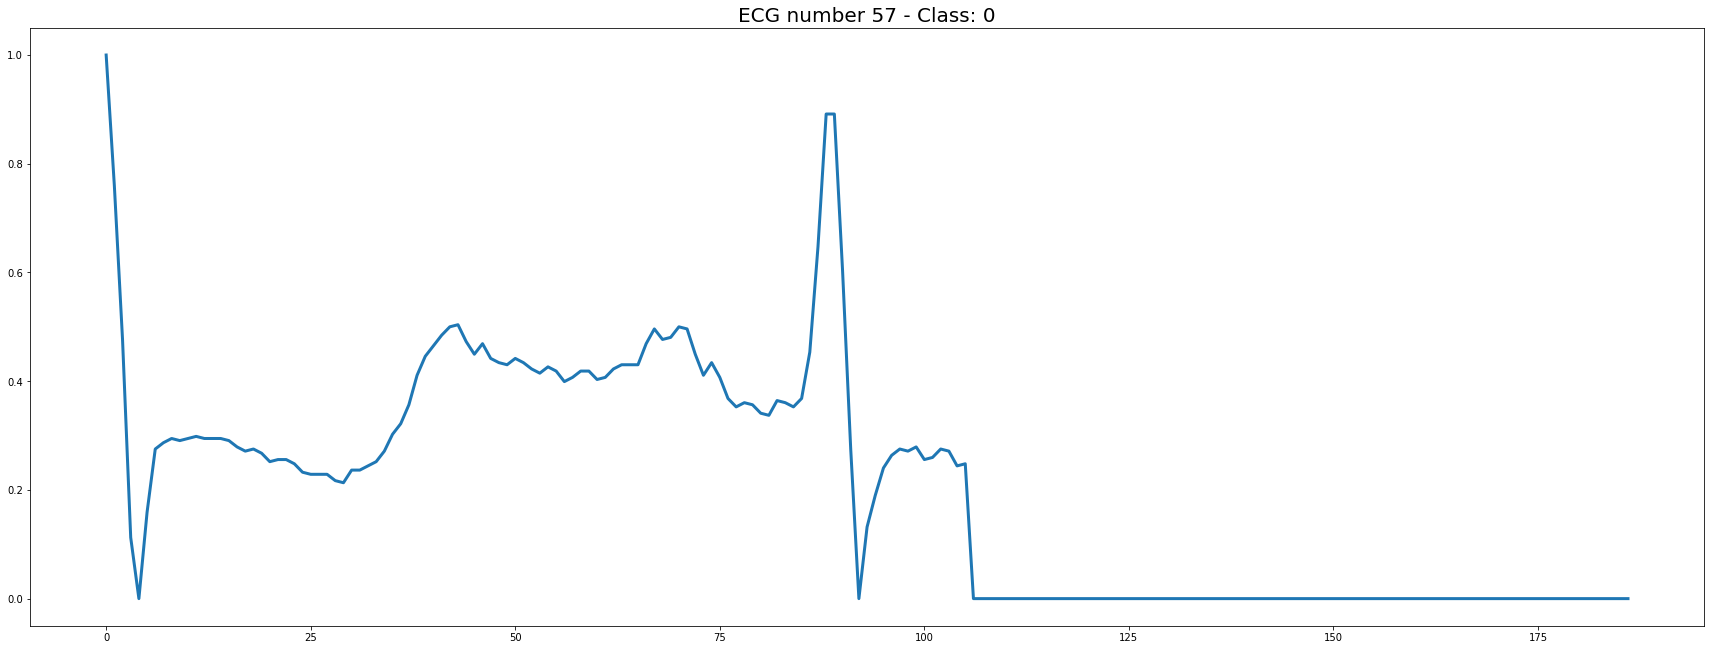

In [7]:
# Plotting one signal
example_signal = 56
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
plt.plot(X[example_signal])
plt.title("ECG number {} - Class: {}".format(example_signal+1, np.argmax(Y[example_signal])), size = 20)
plt.show()

6) Creating validation set

In [8]:
# Splitting dataset for validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
for train_index, test_index in sss.split(X, Y):
    X_train, X_val = X[train_index], X[test_index]
    Y_train, Y_val = Y[train_index], Y[test_index]

print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_val shape is {}".format(X_val.shape))
print("Y_val shape is {}".format(Y_val.shape))

X_train shape is (70043, 187, 1)
Y_train shape is (70043, 5)
X_val shape is (17511, 187, 1)
Y_val shape is (17511, 5)



6) Building SimpleRNN

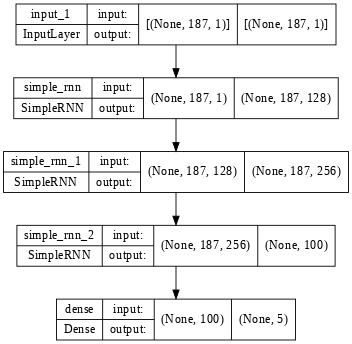

In [9]:
def getSimpleRNN(input_shape, lr=0.001, dr=0.2, n_classes=5):

  inp = Input(shape=input_shape)
  img_1 = SimpleRNN(128, activation=None, dropout=dr, return_sequences=True, unroll=True)(inp)
  img_2 = SimpleRNN(256, activation=None, dropout=dr, return_sequences=True, unroll=True)(img_1)
  img_3 = SimpleRNN(100, activation=None, dropout=dr, return_sequences=False, unroll=True)(img_2)
  out = Dense(5, activation='softmax')(img_3)

  model = models.Model(inputs=inp, outputs=out)
  opt = optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=losses.categorical_crossentropy,
                  metrics=['acc'])
  return model

sRNN = getSimpleRNN(X_train[0].shape)
tf.keras.utils.plot_model(sRNN, show_shapes=True, dpi=64)

In [10]:
# Preparing the model
sRNN_file_path = model_path + "RNN_mit.h5"
checkpoint = ModelCheckpoint(sRNN_file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode="min", patience=25, verbose=1)
callbacks_list = [checkpoint, early]

In [11]:
# Fitting the model
history = sRNN.fit(X_train, Y_train, epochs=1000, verbose=2, callbacks=callbacks_list, batch_size=128, validation_data=(X_val, Y_val))

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.38824, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/RNN_mit.h5
548/548 - 70s - loss: 1.2553 - acc: 0.8339 - val_loss: 0.3882 - val_acc: 0.8855 - 70s/epoch - 128ms/step
Epoch 2/1000

Epoch 2: val_loss did not improve from 0.38824
548/548 - 38s - loss: 0.4781 - acc: 0.8645 - val_loss: 0.4029 - val_acc: 0.8804 - 38s/epoch - 70ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.38824 to 0.38110, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/RNN_mit.h5
548/548 - 41s - loss: 0.4573 - acc: 0.8684 - val_loss: 0.3811 - val_acc: 0.8820 - 41s/epoch - 75ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.38110 to 0.36944, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/RNN_mit.h5
548/548 - 39s - loss: 0.4459 - acc: 0.8720 - val_loss: 0.3694 - val_acc: 0.8881 - 39s/epoch - 70ms/step
Epoch 5/1000

Epoch 5: val_loss did not improve from 0.36944
548/548 - 38s - loss: 0.4463 - acc: 0.8714

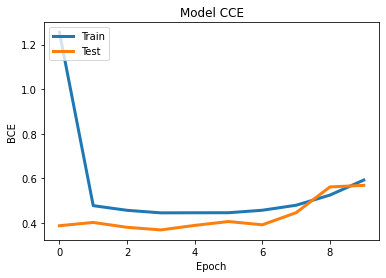

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model CCE')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

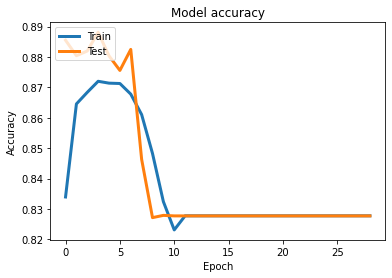

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
# Analysis of the model
sRNN.load_weights(sRNN_file_path)
Y_pred_test = sRNN.predict(X_test)
cce = tf.keras.losses.CategoricalCrossentropy()
print("Model CCE: {}".format(cce(Y_test,Y_pred_test).numpy()))
m = tf.keras.metrics.Accuracy()
m.update_state(np.argmax(Y_test,axis=1), np.argmax(Y_pred_test,axis=1))
print("Model accuracy: {}".format(m.result().numpy()))

Model CCE: 0.37320470809936523
Model accuracy: 0.8881783485412598


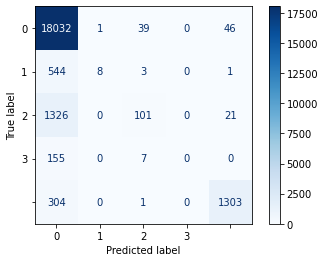

In [15]:
# Plotting confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()